# Bot Detection Analysis Overview

This notebook provides comprehensive analysis of bot detection results:
- Distribution of scores across different detection methods
- Top most likely bots
- Correlations between detection methods
- DeepSeek prompt comparisons

In [19]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data from Database

In [20]:
# Connect to database
conn = sqlite3.connect('bot_detection.db')

# Load bot detection results
bot_results = pd.read_sql_query("""
    SELECT * FROM bot_detection_results
""", conn)

# Load DeepSeek analyses
deepseek = pd.read_sql_query("""
    SELECT * FROM deepseek_analyses
""", conn)

# Load user metadata
users = pd.read_sql_query("""
    SELECT * FROM users
""", conn)

print(f"Loaded {len(bot_results)} bot detection results")
print(f"Loaded {len(deepseek)} DeepSeek analyses")
print(f"Loaded {len(users)} users")

Loaded 1007 bot detection results
Loaded 3988 DeepSeek analyses
Loaded 1007 users


## 1.1 Filter Out Failed LLM Analyses

In [21]:
# Filter out entries where LLM failed (confidence = 0 or null)
print("Before filtering:")
print(f"  Bot results: {len(bot_results)}")
print(f"  DeepSeek analyses: {len(deepseek)}")

# Filter DeepSeek: Remove entries where confidence is 0 or null
deepseek_original_count = len(deepseek)
deepseek = deepseek[(deepseek['confidence'] > 0) & (deepseek['confidence'].notna())]
deepseek_removed = deepseek_original_count - len(deepseek)

# Filter bot_results: Remove entries where llm_analysis_score is null or 0
# (indicating LLM analysis failed)
bot_results_original_count = len(bot_results)
bot_results = bot_results[
    (bot_results['llm_analysis_score'].notna()) & 
    (bot_results['llm_analysis_score'] > 0) &
    (bot_results['confidence'] > 0) &
    (bot_results['confidence'].notna())
]
bot_results_removed = bot_results_original_count - len(bot_results)

print("\nAfter filtering:")
print(f"  Bot results: {len(bot_results)} (removed {bot_results_removed})")
print(f"  DeepSeek analyses: {len(deepseek)} (removed {deepseek_removed})")
print(f"\n✓ Filtered out {deepseek_removed + bot_results_removed} total entries where LLM failed or certainty = 0")

Before filtering:
  Bot results: 1007
  DeepSeek analyses: 3988

After filtering:
  Bot results: 939 (removed 68)
  DeepSeek analyses: 3986 (removed 2)

✓ Filtered out 70 total entries where LLM failed or certainty = 0


## 2. Overall Statistics

In [22]:
print("=" * 60)
print("BOT DETECTION STATISTICS")
print("=" * 60)
print(f"\nTotal users analyzed: {len(bot_results)}")
print(f"\nOverall Bot Score Distribution:")
print(bot_results['overall_score'].describe())
print(f"\nBots (score >= 0.6): {len(bot_results[bot_results['overall_score'] >= 0.6])}")
print(f"Humans (score <= 0.4): {len(bot_results[bot_results['overall_score'] <= 0.4])}")
print(f"Uncertain (0.4 < score < 0.6): {len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])}")

BOT DETECTION STATISTICS

Total users analyzed: 939

Overall Bot Score Distribution:
count    939.000000
mean       0.165383
std        0.090377
min        0.010000
25%        0.095000
50%        0.160000
75%        0.215000
max        0.500000
Name: overall_score, dtype: float64

Bots (score >= 0.6): 0
Humans (score <= 0.4): 924
Uncertain (0.4 < score < 0.6): 15


## 3. Score Distributions by Method

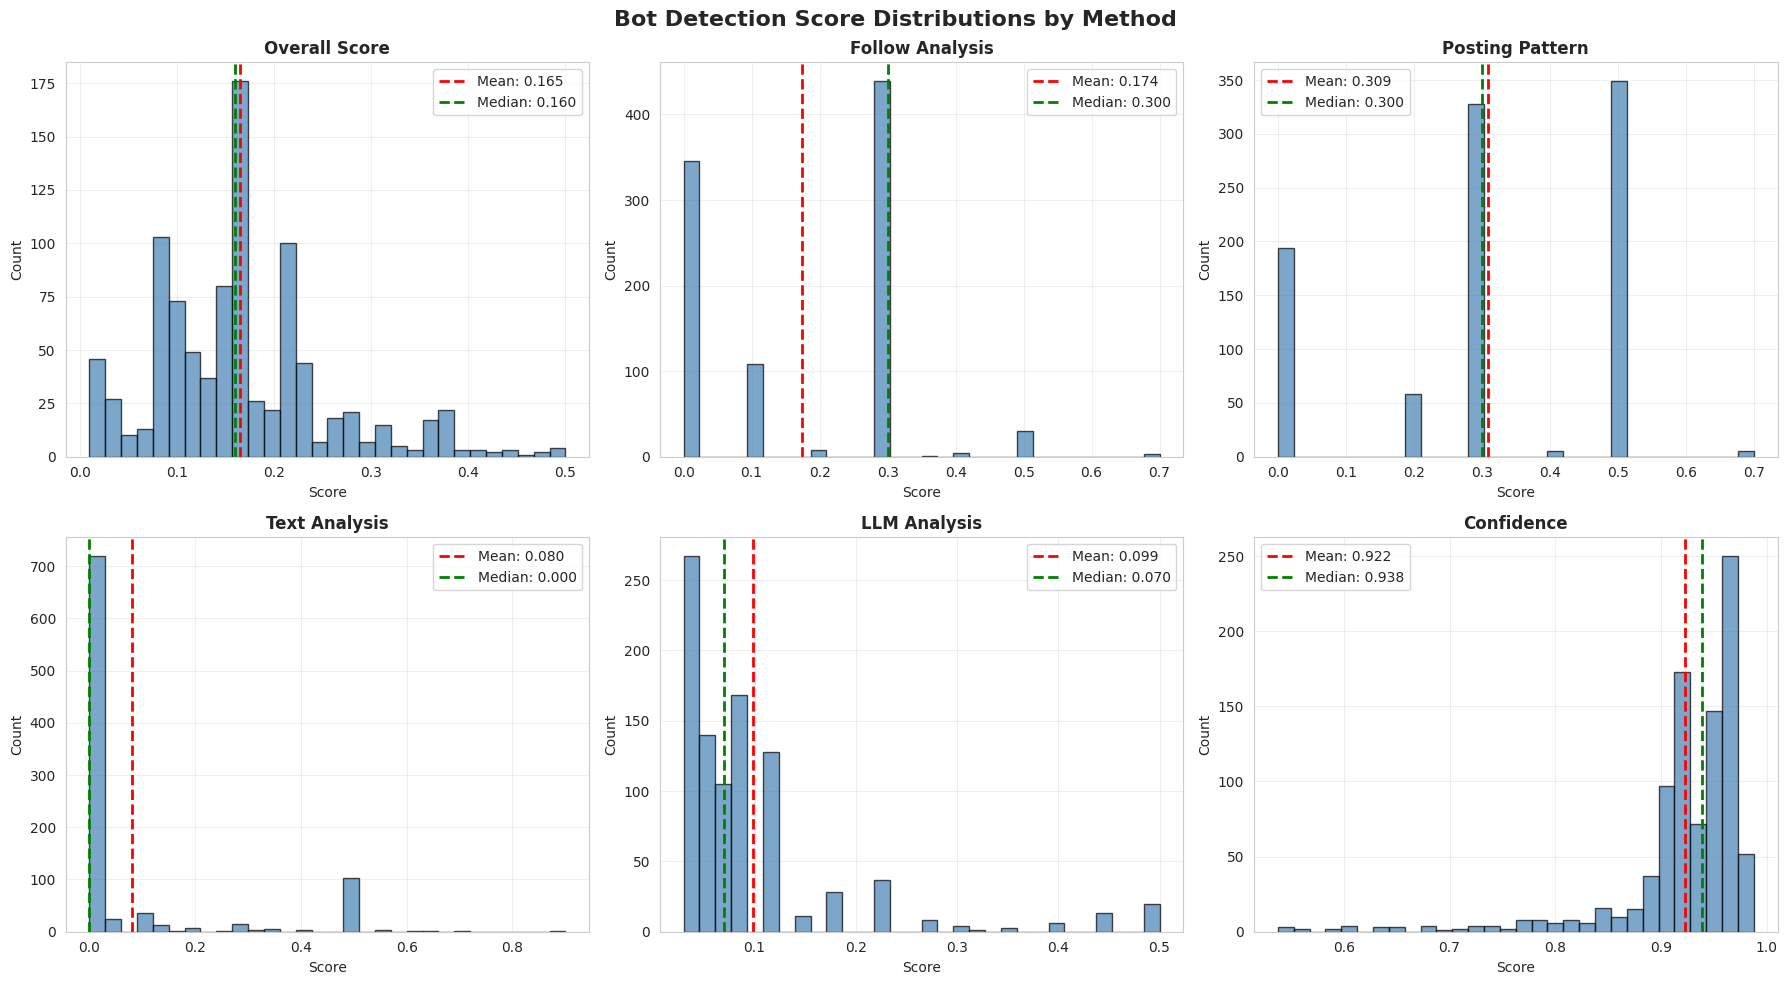

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Bot Detection Score Distributions by Method', fontsize=16, fontweight='bold')

methods = [
    ('overall_score', 'Overall Score'),
    ('follow_analysis_score', 'Follow Analysis'),
    ('posting_pattern_score', 'Posting Pattern'),
    ('text_analysis_score', 'Text Analysis'),
    ('llm_analysis_score', 'LLM Analysis'),
    ('confidence', 'Confidence')
]

for idx, (col, title) in enumerate(methods):
    ax = axes[idx // 3, idx % 3]
    
    # Histogram
    ax.hist(bot_results[col].dropna(), bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(bot_results[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {bot_results[col].mean():.3f}')
    ax.axvline(bot_results[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {bot_results[col].median():.3f}')
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Method Correlations

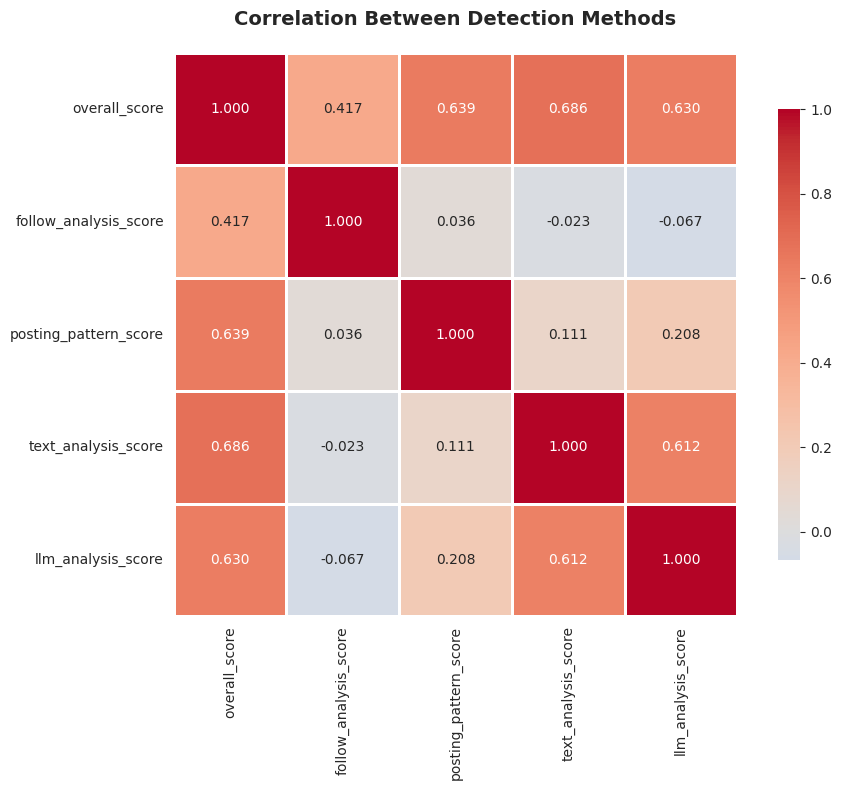


Correlation Insights:
  overall_score <-> posting_pattern_score: 0.639 (Moderate)
  overall_score <-> text_analysis_score: 0.686 (Moderate)
  overall_score <-> llm_analysis_score: 0.630 (Moderate)
  text_analysis_score <-> llm_analysis_score: 0.612 (Moderate)


In [24]:
# Calculate correlation matrix
score_cols = ['overall_score', 'follow_analysis_score', 'posting_pattern_score', 
              'text_analysis_score', 'llm_analysis_score']
corr_matrix = bot_results[score_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Detection Methods', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
for i, method1 in enumerate(score_cols[:-1]):
    for method2 in score_cols[i+1:]:
        corr_val = corr_matrix.loc[method1, method2]
        if abs(corr_val) > 0.5:
            print(f"  {method1} <-> {method2}: {corr_val:.3f} ({'Strong' if abs(corr_val) > 0.7 else 'Moderate'})")

## 5. Top Likely Bots

TOP 20 MOST LIKELY BOTS
                     handle  overall_score  confidence  follow_analysis_score  posting_pattern_score  text_analysis_score  llm_analysis_score                                                                                                                                          summary
       eriklund.bsky.social         0.5000    0.600000                    0.5                    0.5                  0.5                0.50        Analysis of @eriklund.bsky.social indicates this account is unclear - needs further investigation (risk level: MEDIUM, score: 0.50/1.00).
 onlygoodplayer.bsky.social         0.5000    0.600000                    0.5                    0.5                  0.5                0.50  Analysis of @onlygoodplayer.bsky.social indicates this account is unclear - needs further investigation (risk level: MEDIUM, score: 0.50/1.00).
     pdelacroix.bsky.social         0.5000    0.600000                    0.5                    0.5               

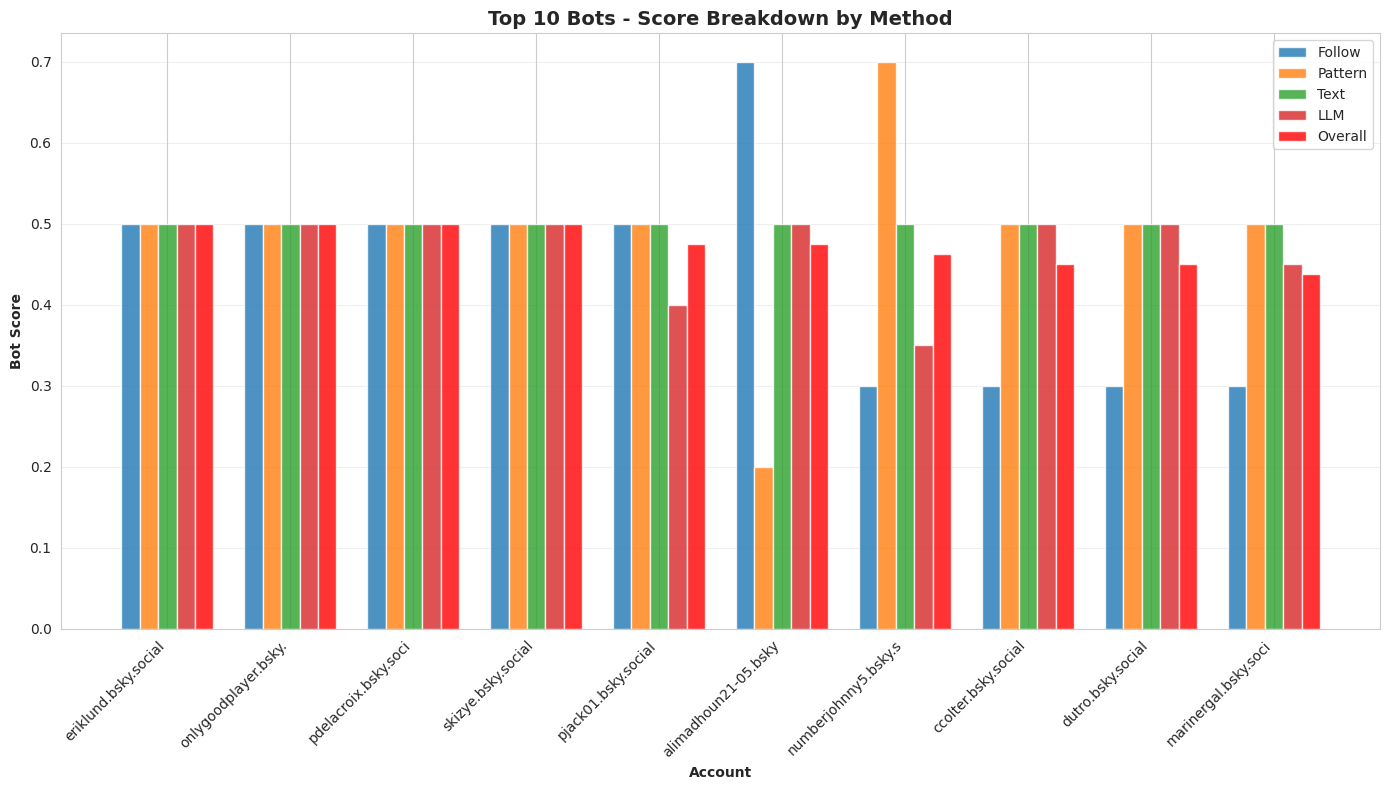

In [33]:
# Top 20 most likely bots
top_bots = bot_results.nlargest(20, 'overall_score')[[
    'handle', 'overall_score', 'confidence', 'follow_analysis_score', 
    'posting_pattern_score', 'text_analysis_score', 'llm_analysis_score','summary'
]]

print("=" * 100)
print("TOP 20 MOST LIKELY BOTS")
print("=" * 100)
print(top_bots.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))
top_10 = bot_results.nlargest(10, 'overall_score')
x = range(len(top_10))
width = 0.15

ax.bar([i - 2*width for i in x], top_10['follow_analysis_score'], width, label='Follow', alpha=0.8)
ax.bar([i - width for i in x], top_10['posting_pattern_score'], width, label='Pattern', alpha=0.8)
ax.bar(x, top_10['text_analysis_score'], width, label='Text', alpha=0.8)
ax.bar([i + width for i in x], top_10['llm_analysis_score'], width, label='LLM', alpha=0.8)
ax.bar([i + 2*width for i in x], top_10['overall_score'], width, label='Overall', alpha=0.8, color='red')

ax.set_xlabel('Account', fontweight='bold')
ax.set_ylabel('Bot Score', fontweight='bold')
ax.set_title('Top 10 Bots - Score Breakdown by Method', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([h[:20] for h in top_10['handle']], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. DeepSeek Prompt Analysis

In [26]:
# Pivot DeepSeek data for analysis
deepseek_pivot = deepseek.pivot_table(
    index='handle',
    columns='prompt_name',
    values=['assessment', 'confidence'],
    aggfunc='first'
)

# Count assessments per prompt
prompt_counts = deepseek.groupby(['prompt_name', 'assessment']).size().unstack(fill_value=0)

print("=" * 60)
print("DEEPSEEK PROMPT ANALYSIS")
print("=" * 60)
print("\nAssessment counts by prompt:")
print(prompt_counts)

# Calculate bot detection rate per prompt
prompt_bot_rate = deepseek[deepseek['assessment'] == 'ai_bot'].groupby('prompt_name').size() / deepseek.groupby('prompt_name').size()
print("\nBot detection rate by prompt:")
for prompt, rate in prompt_bot_rate.items():
    print(f"  {prompt}: {rate*100:.1f}%")

DEEPSEEK PROMPT ANALYSIS

Assessment counts by prompt:
assessment   ai_bot  human
prompt_name               
prompt1         211    785
prompt2         287    710
prompt3         912     84
prompt4         164    833

Bot detection rate by prompt:
  prompt1: 21.2%
  prompt2: 28.8%
  prompt3: 91.6%
  prompt4: 16.4%


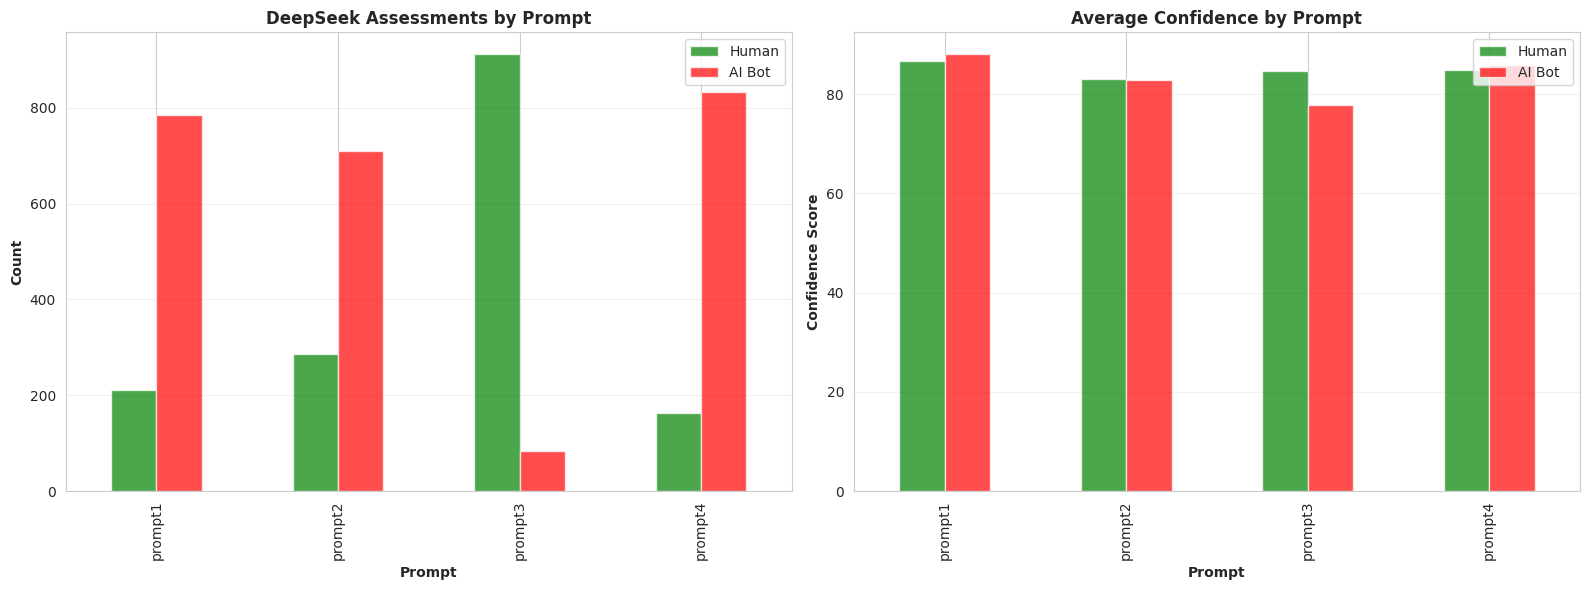

In [27]:
# Visualize prompt comparisons
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Assessment distribution
prompt_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('DeepSeek Assessments by Prompt', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prompt', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].legend(['Human', 'AI Bot'])
axes[0].grid(True, alpha=0.3, axis='y')

# Average confidence by prompt and assessment
conf_by_prompt = deepseek.groupby(['prompt_name', 'assessment'])['confidence'].mean().unstack(fill_value=0)
conf_by_prompt.plot(kind='bar', ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Average Confidence by Prompt', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Prompt', fontweight='bold')
axes[1].set_ylabel('Confidence Score', fontweight='bold')
axes[1].legend(['Human', 'AI Bot'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Agreement Between DeepSeek Prompts

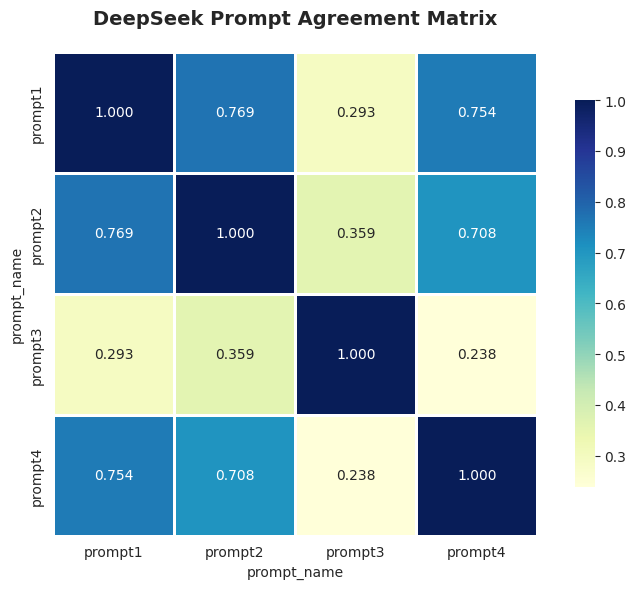


Prompt Agreement Insights:
  prompt1 <-> prompt2: 76.9% agreement
  prompt1 <-> prompt3: 29.3% agreement
  prompt1 <-> prompt4: 75.4% agreement
  prompt2 <-> prompt3: 35.9% agreement
  prompt2 <-> prompt4: 70.8% agreement
  prompt3 <-> prompt4: 23.8% agreement


In [28]:
# Check how often prompts agree
prompt_assessments = deepseek.pivot_table(
    index='handle',
    columns='prompt_name',
    values='assessment',
    aggfunc='first'
)

# Convert to binary (1 = ai_bot, 0 = human)
prompt_binary = (prompt_assessments == 'ai_bot').astype(int)

# Calculate agreement matrix
agreement_matrix = pd.DataFrame(index=prompt_binary.columns, columns=prompt_binary.columns)

for p1 in prompt_binary.columns:
    for p2 in prompt_binary.columns:
        if p1 == p2:
            agreement_matrix.loc[p1, p2] = 1.0
        else:
            # Calculate agreement rate
            agreement = (prompt_binary[p1] == prompt_binary[p2]).sum() / len(prompt_binary)
            agreement_matrix.loc[p1, p2] = agreement

agreement_matrix = agreement_matrix.astype(float)

# Plot agreement heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('DeepSeek Prompt Agreement Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nPrompt Agreement Insights:")
for i, p1 in enumerate(prompt_binary.columns[:-1]):
    for p2 in prompt_binary.columns[i+1:]:
        agree_rate = agreement_matrix.loc[p1, p2]
        print(f"  {p1} <-> {p2}: {agree_rate*100:.1f}% agreement")

## 8. Comparison: Our Detection vs DeepSeek

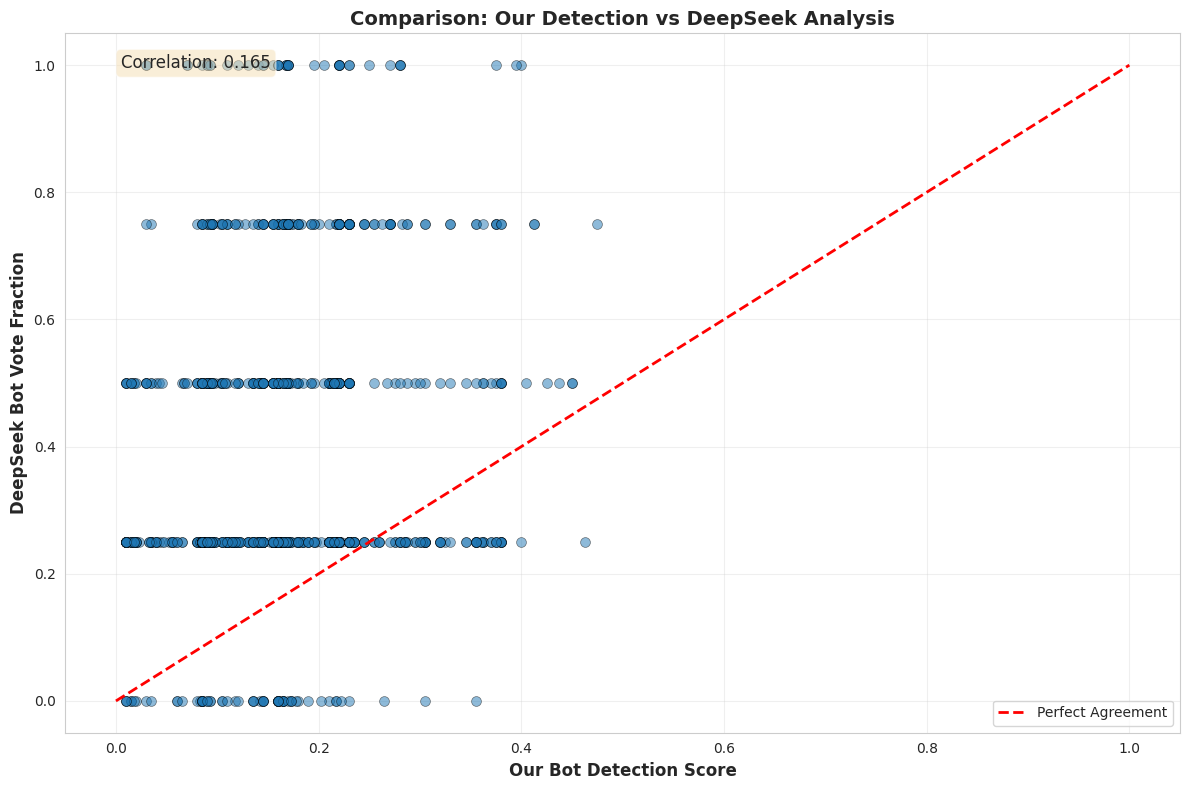


Correlation between our score and DeepSeek: 0.165

Agreement on strong cases:
  Both say bot (our >0.6, DS >0.5): 0
  Both say human (our <0.4, DS <0.5): 543
  Disagreement (our >0.6 but DS <0.5): 0
  Disagreement (our <0.4 but DS >0.5): 167


In [29]:
# Merge bot detection with DeepSeek majority vote
deepseek_votes = prompt_binary.sum(axis=1) / len(prompt_binary.columns)  # Fraction voting "bot"

comparison = bot_results[['handle', 'overall_score']].copy()
comparison = comparison.merge(deepseek_votes.reset_index().rename(columns={0: 'deepseek_bot_fraction'}), 
                              on='handle', how='inner')

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(comparison['overall_score'], comparison['deepseek_bot_fraction'], 
           alpha=0.5, s=50, edgecolors='black', linewidth=0.5)

# Add diagonal line for perfect agreement
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')

# Add correlation
corr = comparison['overall_score'].corr(comparison['deepseek_bot_fraction'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('Our Bot Detection Score', fontweight='bold', fontsize=12)
plt.ylabel('DeepSeek Bot Vote Fraction', fontweight='bold', fontsize=12)
plt.title('Comparison: Our Detection vs DeepSeek Analysis', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nCorrelation between our score and DeepSeek: {corr:.3f}")
print(f"\nAgreement on strong cases:")
print(f"  Both say bot (our >0.6, DS >0.5): {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] > 0.5)])}")
print(f"  Both say human (our <0.4, DS <0.5): {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] < 0.5)])}")
print(f"  Disagreement (our >0.6 but DS <0.5): {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] < 0.5)])}")
print(f"  Disagreement (our <0.4 but DS >0.5): {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] > 0.5)])}")

## 9. Export Summary Report

In [30]:
# Create summary report
summary_report = f"""
====================================================================
                BOT DETECTION ANALYSIS SUMMARY REPORT
====================================================================

Dataset Size:
  - Total users analyzed: {len(bot_results)}
  - Total DeepSeek analyses: {len(deepseek)}

Our Bot Detection Results:
  - Mean overall score: {bot_results['overall_score'].mean():.3f}
  - Classified as bots (score >= 0.6): {len(bot_results[bot_results['overall_score'] >= 0.6])} ({len(bot_results[bot_results['overall_score'] >= 0.6])/len(bot_results)*100:.1f}%)
  - Classified as humans (score <= 0.4): {len(bot_results[bot_results['overall_score'] <= 0.4])} ({len(bot_results[bot_results['overall_score'] <= 0.4])/len(bot_results)*100:.1f}%)
  - Uncertain (0.4 < score < 0.6): {len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])} ({len(bot_results[(bot_results['overall_score'] > 0.4) & (bot_results['overall_score'] < 0.6)])/len(bot_results)*100:.1f}%)

Method Scores (Mean):
  - Follow analysis: {bot_results['follow_analysis_score'].mean():.3f}
  - Posting pattern: {bot_results['posting_pattern_score'].mean():.3f}
  - Text analysis: {bot_results['text_analysis_score'].mean():.3f}
  - LLM analysis: {bot_results['llm_analysis_score'].mean():.3f}

DeepSeek Analysis:
  - Bot detection rates by prompt:
{chr(10).join([f'    - {p}: {r*100:.1f}%' for p, r in prompt_bot_rate.items()])}

Agreement:
  - Correlation (Our vs DeepSeek): {corr:.3f}
  - Both agree on bots: {len(comparison[(comparison['overall_score'] > 0.6) & (comparison['deepseek_bot_fraction'] > 0.5)])}
  - Both agree on humans: {len(comparison[(comparison['overall_score'] < 0.4) & (comparison['deepseek_bot_fraction'] < 0.5)])}

====================================================================
"""

print(summary_report)

# Save to file
with open('analysis_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'analysis_summary_report.txt'")


                BOT DETECTION ANALYSIS SUMMARY REPORT

Dataset Size:
  - Total users analyzed: 939
  - Total DeepSeek analyses: 3986

Our Bot Detection Results:
  - Mean overall score: 0.165
  - Classified as bots (score >= 0.6): 0 (0.0%)
  - Classified as humans (score <= 0.4): 924 (98.4%)
  - Uncertain (0.4 < score < 0.6): 15 (1.6%)

Method Scores (Mean):
  - Follow analysis: 0.174
  - Posting pattern: 0.309
  - Text analysis: 0.080
  - LLM analysis: 0.099

DeepSeek Analysis:
  - Bot detection rates by prompt:
    - prompt1: 21.2%
    - prompt2: 28.8%
    - prompt3: 91.6%
    - prompt4: 16.4%

Agreement:
  - Correlation (Our vs DeepSeek): 0.165
  - Both agree on bots: 0
  - Both agree on humans: 543



✓ Summary report saved to 'analysis_summary_report.txt'


In [31]:
# Close database connection
conn.close()
print("\n✓ Analysis complete!")


✓ Analysis complete!


In [32]:
#Get most likely bots combined deepseek scores
most_likely_bots_deepseek = deepseek.groupby('handle').apply(lambda df: (df['assessment'] == 'ai_bot').mean()).reset_index()
most_likely_bots_deepseek.columns = ['handle', 'bot_vote_fraction']
most_likely_bots_deepseek = most_likely_bots_deepseek.sort_values(by='bot_vote_fraction', ascending=False).head(20)
print("=" * 100)
print("TOP 20 MOST LIKELY BOTS BASED ON DEEPSEEK SCORES")
print("=" * 100)
print(most_likely_bots_deepseek.to_string(index=False)) 


TOP 20 MOST LIKELY BOTS BASED ON DEEPSEEK SCORES
                       handle  bot_vote_fraction
          jaculis.bsky.social                1.0
    jacqueline321.bsky.social                1.0
     vehementsack.bsky.social                1.0
  jan6risingvoice.bsky.social                1.0
       jameslay86.bsky.social                1.0
          ampule2.bsky.social                1.0
       irishicesp.bsky.social                1.0
          viklake.bsky.social                1.0
         anetjane.bsky.social                1.0
         theender.bsky.social                1.0
   thetruthisblue.bsky.social                1.0
      lauralpharm.bsky.social                1.0
    stopthesweeps.bsky.social                1.0
      loismarlene.bsky.social                1.0
thegopisfubar2024.bsky.social                1.0
         sebright.bsky.social                1.0
      sghendricks.bsky.social                1.0
       mifterchip.bsky.social                1.0
       michael859.bs

/tmp/ipykernel_397037/3842351954.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_likely_bots_deepseek = deepseek.groupby('handle').apply(lambda df: (df['assessment'] == 'ai_bot').mean()).reset_index()
